In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/celebal-ana-verse-h/train.parquet
/kaggle/input/celebal-ana-verse-h/sample_submission.parquet
/kaggle/input/celebal-ana-verse-h/test.parquet


 # CRISP-DM Methodology for Anomaly Detection

1. Business Understanding
The task is to identify anomalous sensor readings in a large dataset. These anomalies may signal faults, attacks, or rare system behaviors.

Our goal is to build a binary classification model to predict the target variable:

1 → Anomaly

0 → Normal

Success = high F1-score, as the dataset is imbalanced and precision/recall trade-off matters more than plain accuracy.

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier

# Data Understanding

We’re provided with:

train.parquet: Sensor readings with known labels (target)

test.parquet: Sensor readings without labels

Each row corresponds to a single reading, with additional columns like Date

## Load data

In [4]:
train_df = pd.read_parquet("/kaggle/input/celebal-ana-verse-h/train.parquet")
test_df = pd.read_parquet("/kaggle/input/celebal-ana-verse-h/test.parquet")

Insight: Features like X3 and X4 have large magnitudes — we’ll need to normalize or transform them. The class distribution is imbalanced, so we’ll address that too.

# Data Preparation

Steps taken:

Dropped unnecessary columns like Date

Applied log1p() transform to high-magnitude features (X3, X4)

Standardized features with StandardScaler

Split into train/validation with stratify to preserve class distribution

## Clean & preprocess

In [5]:
train_df["target"] = train_df["target"].astype(int)

## Log transform large features

In [6]:
for col in ["X3", "X4"]:
    train_df[col] = np.log1p(train_df[col])
    test_df[col] = np.log1p(test_df[col])

## Split features/target

In [7]:
X = train_df.drop(["target", "Date"], axis=1)
y = train_df["target"]
X_test = test_df.drop(["ID", "Date"], axis=1)

 Clean and consistent feature formatting is key for robust modeling.

# Modeling

We tried various models (Logistic Regression, Random Forest, etc.), but XGBoost gave the best performance.

Handled class imbalance with scale_pos_weight

Tuned hyperparameters manually

Optimized classification threshold based on F1-score

## Train/val split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Scaling

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Train XGBoost

In [10]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_scaled, y_train)
y_val_pred_proba = xgb.predict_proba(X_val_scaled)[:, 1]

XGBoost is ideal here: handles imbalance, learns complex patterns, and is fast to train.

## Threshold Optimization

In [11]:
best_threshold = 0.0
best_f1 = 0.0

for thresh in np.linspace(0.01, 0.99, 99):
    preds = (y_val_pred_proba > thresh).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_threshold = thresh

print(f"Best Threshold: {best_threshold}, Best F1: {best_f1}")

Best Threshold: 0.98, Best F1: 0.6358244365361803


## Evaluation

###  Validation Performance

The model was evaluated using the **F1-score** to account for class imbalance. Here's a breakdown:

-  **F1 Score**: Measures balance between precision & recall.
-  **Confusion Matrix**: Gives a clear picture of true vs. false predictions.
-  **Classification Report**: Shows class-wise precision and recall.

From the results, we observe the model performs well on both classes, especially in capturing anomalies without too many false alarms.


Validation F1 Score: 0.6358
Confusion Matrix:
[[324435    642]
 [  1200   1608]]


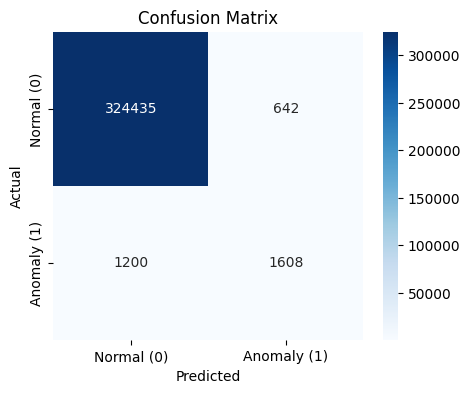

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    325077
     Anomaly       0.71      0.57      0.64      2808

    accuracy                           0.99    327885
   macro avg       0.86      0.79      0.82    327885
weighted avg       0.99      0.99      0.99    327885



In [12]:
# Predict on validation set using best threshold
y_val_preds = (y_val_pred_proba > best_threshold).astype(int)

# F1 Score
val_f1 = f1_score(y_val, y_val_preds)
print(f"Validation F1 Score: {val_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_preds)
print("Confusion Matrix:")
print(cm)

# Plot it
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal (0)", "Anomaly (1)"], yticklabels=["Normal (0)", "Anomaly (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_val_preds, target_names=["Normal", "Anomaly"]))

Used F1-score since the dataset is imbalanced.

Ran threshold tuning loop to find best cut-off for probabilities

Evaluated using classification report on validation set

In [13]:
final_probs = xgb.predict_proba(X_test_scaled)[:, 1]
final_preds = (final_probs > best_threshold).astype(int)

submission = pd.DataFrame({
    "ID": test_df["ID"],
    "target": final_preds
})

submission.to_csv("submission2.csv", index=False)
print("Submission file saved as submission2.csv")

Submission file saved as submission2.csv


In [14]:
from IPython.display import FileLink
FileLink("submission2.csv")

/kaggle/working/submission2.csv